In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 3. Brownian Motion Simulation

- I will conduct the simulation in discrete time intervals, where in each time interval, particles moves in both X and Y directions in non-fixed step sizes.
- To generate the steps I will use np.random.randn() function which generates values that follow standard normal distribution with $\mu = 0$ and $\sigma = 1$
- To get the coordinates at the time intervals, I will use np.cumsum() to accumulate the steps.

In [445]:
iterations = 500
X = np.cumsum(np.concatenate((np.array([1]), np.random.randn(iterations)), axis = None))
Y = np.cumsum(np.concatenate((np.array([1]), np.random.randn(iterations)), axis = None))

Text(0.5, 1.0, "Starting in point 'O', particle wandered, and ended in point 'X'")

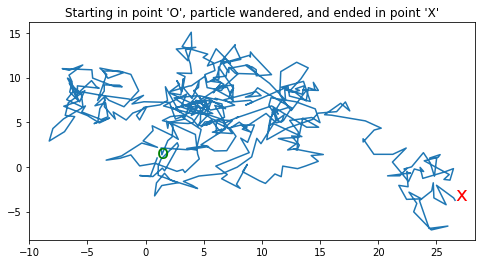

In [480]:
fig, ax = plt.subplots(figsize = (8, 4))
plt.plot(X, Y)
ax.annotate('o', (X[0], Y[0]), size = 20, color = 'green')
ax.annotate('x', (X[-1], Y[-1]), size = 20, color = 'red')
ax.set_title("Starting in point 'O', particle wandered, and ended in point 'X'")

- OK Brownian motion is observed in action and it seems to work fine.

In [462]:
def brownian_motion(iterations):
    lst_of_x_coordinates_when_y_0 = []
    for i in range(iterations):
        # starting coordinates
        lst_X = [1] 
        lst_Y = [1]
        
        # while the particle is on the north side of X axis, it will keep moving, until it hits y = 0
        while np.cumsum(lst_Y)[-1] > 0:
            lst_X.append(np.random.randn())
            lst_Y.append(np.random.randn())
        lst_of_x_coordinates_when_y_0.append(np.cumsum(lst_X)[-1])
    return lst_of_x_coordinates_when_y_0

- I want to test the function in-detail before running the parallel simulations
- I need to see that the simulation indeed ends only when the particle hits y = 0

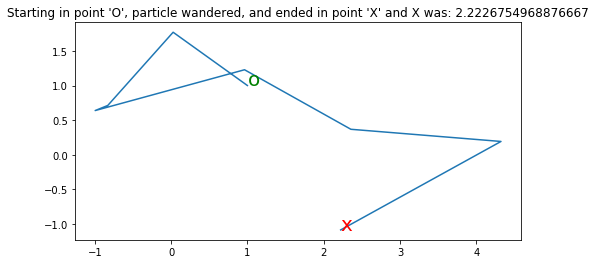

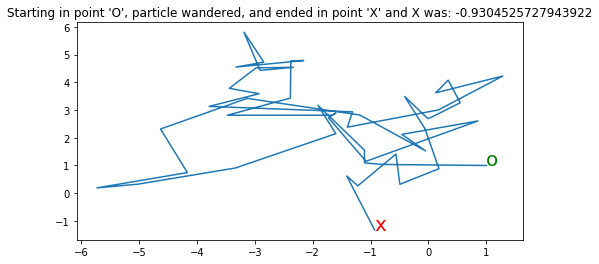

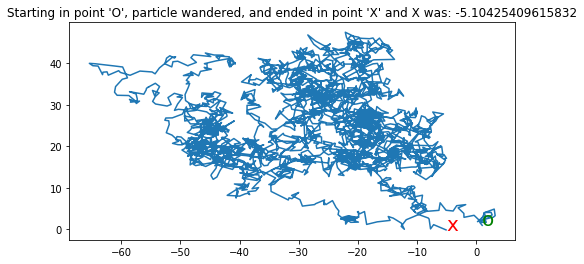

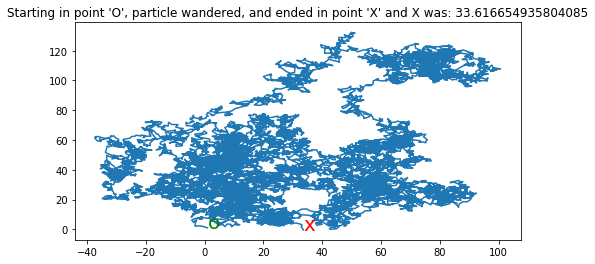

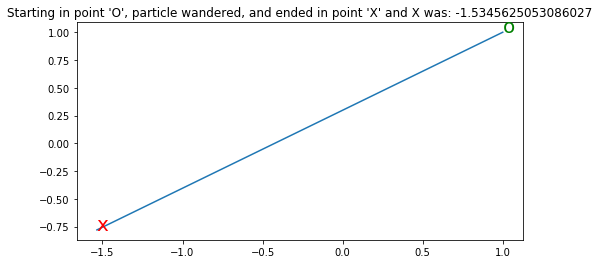

In [492]:
for i in range(5):
    # starting coordinates
    lst_X = [1] 
    lst_Y = [1]

    # while the particle is on the north side of X axis, it will keep moving, until it hits y = 0
    while np.cumsum(lst_Y)[-1] > 0:
        lst_X.append(np.random.randn())
        lst_Y.append(np.random.randn())
    lst_of_x_coordinates_when_y_0.append(np.cumsum(lst_X)[-1])

    X = np.cumsum(lst_X)
    Y = np.cumsum(lst_Y)

    fig, ax = plt.subplots(figsize = (8, 4))
    plt.plot(X, Y)
    ax.annotate('o', (X[0], Y[0]), size = 20, color = 'green')
    ax.annotate('x', (X[-1], Y[-1]), size = 20, color = 'red')
    ax.set_title("Starting in point 'O', particle wandered, and ended in point 'X' and X was: " + str (X[-1]))

- OK code seems to be working correctly, with simulation ending once the particles goes south of y = 0 axis
- Some of them took very long time, funny enough

- I will use multiprocessing to speed-up the simulations which will also enable me to get better results with higher number of iterations
- PS: Multiprocessing in Jupyter only works in Linux, so if you want to test the code in Windows, you need to copy it into a .py file and then, run it, otherwise multiprocessing won't work

In [463]:
import concurrent.futures

In [512]:
%%time
main_list = []
iterations = 250
list_iterations = 64 * [iterations]

with concurrent.futures.ProcessPoolExecutor(max_workers = 64) as executor:
    for returned_object in executor.map(brownian_motion, list_iterations):
        main_list.append(returned_object)
        
x_coordinates = np.array(main_list).reshape(-1)

CPU times: user 132 ms, sys: 952 ms, total: 1.08 s
Wall time: 3min 20s


In [513]:
(x_coordinates < 0).sum() / len(x_coordinates)

0.344

- Running the simulation for 16.000 times (because I had 64 cores x 250 iterations) the result is 0.344.
- Therefore, P(X < 0 | Y = 0) = 0.344

- Since I collected the results regardless of T, I can simply plot for various T values without being have to re-run the simulation

In [532]:
list_T = np.linspace(-25, +25, 1000)
list_P = []
for T in list_T:
    list_P.append((x_coordinates < T).sum() / len(x_coordinates))

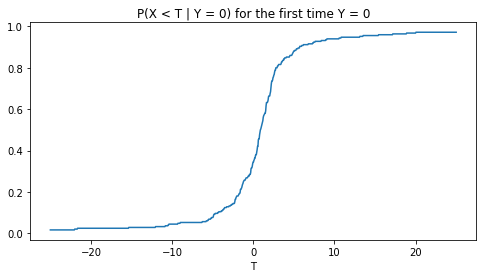

In [635]:
df_P_T = pd.DataFrame({'T': list_T, 'P': list_P}).set_index('T')
df_P_T.plot(figsize = (8, 4), title = 'P(X < T | Y = 0) for the first time Y = 0', legend = False)

- This is a logistic curve. 
- It makes sense to see this distribution because the probability of seeing the particle in a very negative X coordinate is unlikely. But this is a CUMULATIVE probability distribution because what I have plotted is the answer to the question "What is the probability of seeing the particular in an X coordinate LESS THAN T, when it hits the y = 0 for the first time?". Therefore as the T increases, it accumulates more and more.
- From this data, it is possible to derive the probability of the particle being in a specific X coordinate given y = 0. Since this is the cumulative probability distribution, I need to derive it once.

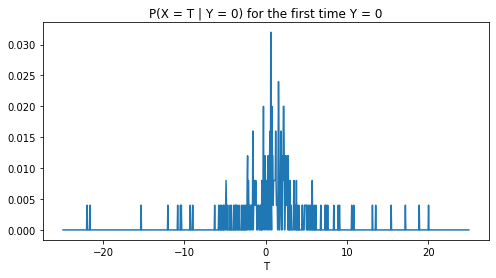

In [636]:
df_P_T.diff().plot(figsize = (8, 4), title = 'P(X = T | Y = 0) for the first time Y = 0', legend = False)

- TA DA. It's Gaussian distribution. It is very unlikely for particle to be far from starting point while it is more likely to be around (1, 1). But it will mostly stay around where it started 
- Notice that the title of the figure now is 'P(X = T | Y = 0) for the first time Y = 0', compared to $< $